# Exploratory data analysis and feature selection: Random Forest

Fabiana Castiblanco

https://github.com/fabi-cast

## Conclusions from EDA

* Philipines, China, Japan, Mexico, Vietnam, United States and Madagascar are the countries with highest occurrence of cyclones. In GitHub, please see the static image [here](https://github.com/omdena/wfpdisrel/blob/master/%23task3-model/model-e-RandomForest/Plots/map.png)

* By far, most of the storms for which we have data have occurred in **Western North Pacific** basin.

* We observed that the distribution of the logarithm natural of our target variable is approximately normal, so ``TOTAL_AFFECTED`` has a distribution log normal. For this reason, when studying the relevance of the categorical features as ``BASIN``, ``SUB BASIN`` and ``GENERAL_CATEGORY`` in the target variable, we will consider the aggregated function as the **mean** of the data.

* After introduction of the variable ``GENERAL_CATEGORY`` which classify the cyclone according with the maximum sustained winds it tooks during their trajectory, we have a much better landscape. Most of our cyclones are **Tropical Storms** and **Hurricanes Category 1 and 4**. Generally, after a cyclone reach winds which classify it as Category 1, there are affected population and some infrastructure damages.

* In the Westert North Pacific basin, for which we have most data, **the mean affected people by the cyclone is going upwards most of the time when the category of the cyclone increases**. After this, we will include the feature ``GENERAL_CATEGORY`` as a dummy variable in our data set.

* In general, countries with higher income level have less affected population in each cyclone category. Critical sectors are countries with ``INCOME_LEVEL`` Low middle and High Middle. We will include ``INCOME_LEVEL`` as a dummy variable in our data set.

* The top 10 most important features, out of the a posteriori ones (``TOTAL_DEATHS`` AND ``TOTAL_DAMAGE``), are:
    * 34_KN_POP
    * Rural population
    * 64_KN_POP
    * Rural population share
    * Human Development Index (HDI)
    * GDP per capita
    * Total hours in land
    * 96_KN_POP
    * Landing (yes/no)
    * Minimum distance to land

None of the a priori variables shows high correlation in general. 

* Almost **3 of each 4 cyclones present in our data did land**. Those landing cyclones are responsible for **almost 95% of the affected population in our data**. 


## Conclusions from modeling task

* By adding new features to the data set, we obtain a R^2 score of 0.30 without scaling our data set. On the other hand, we got a RMSE of 1'606312 people and a Median Absolute error of 230201 people. 

* Using logarithmic transformation in the population variables, we don't see any improvement in the R^2 score or RMSE. On the contrary, those two metrics drop after such transformation.

* Using all the features given in the data set it is harmful for the model itself. There are so many variables not explanatory, most of them comming from socio-economical indicators.

* The recurrent most important features are:

    * RURAL_POP
    * POP_MAX_34_ADJ
    * MAX_WIND
    * RURAL_POP (%)
    * POP_MAX_50_ADJ
    * MAX_STORMSPEED
    * VLAND_KN
    * LON_MAX_WINDS
    * LAT_MIN_DIST2LAND
    * TOTAL_HOURS_INLAND
    * POP_MAX_64_ADJ

## 1. Import libraries


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import math
import requests
import json
import matplotlib
from pandas import ExcelFile
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import geopandas as gp
import reverse_geocoder as rg
import fiona
import ast
import statsmodels.api as sm
import pickle
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)
import sklearn
matplotlib.rc('image', cmap='Set3')
from plotly import graph_objects as go
import plotly.express as px
from scicolorscales import *
from plotly.subplots import make_subplots

# 2. Functions to handling data

In [2]:
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

def get_country_list(ds, col):
    
    """
    Returns a list containing the countries or ISO codes in the dataset ds
    """
    return list(ds[col])

#this function converts a row oriented data set in a columns oriented one

def get_data(ds, country, col, col_name):
    
    """
    Creates a dataset for each country containing the features in col_name.
    ds is the original data set, col is the name of the column containing information about
    countries and col_name is the desired feature to get from ds
    """
    ind = get_country_list(ds, col).index(country)
    data = (ds[ds[col] == country].drop(columns = [col])
                                  .T.reset_index()
                                  .rename(columns = {"index": "year", ind: col_name}))
    data["country"] = country
    return data

def get_table(ds, col, col_name):
    
    """
    Creates a dataset column oriented based on row oriented ds
    """
    
    country_list = get_country_list(ds, col)
    datasets = [get_data(ds, country, col, col_name) for country in country_list]
    return pd.concat(datasets).reset_index(drop = True)
    


# 3. Loading data

In [3]:
df = pd.read_excel("Data_output/clean.xls").drop(columns = "Unnamed: 0")

In [4]:
ds = pd.read_excel("Data_output/final_data.xls").drop(columns = "Unnamed: 0")

In [5]:
df.head()

,SID,NAME,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,DATE_START,DATE_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,LAT_MAX_WINDS,LON_MAX_WINDS,LAT_MIN_DIST2LAND,LON_MIN_DIST2LAND,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,TOTAL_AFFECTED,pop_max_34,pop_max_50,pop_max_64,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj
0,1949163N07145,DELLA,WP,WP,JPN,1949,6,1949-06-19 09:00:00,1949-06-24 06:00:00,117.0,60.0,TS,28.91410,129.573,33.5183,130.973,Cat 4,116.0,952,0,33.0,3,0,99.82,3889.480640,3632.626180,194046,16431894.0,7958809.0,4553851.00,1.198300e+07,5.803981e+06,3.320907e+06
1,1950241N23140,JANE,WP,WP,JPN,1950,8,1950-08-30 03:00:00,1950-09-05 00:00:00,141.0,21.0,ET,29.12010,133.762,36.1016,136.095,Cat 4,116.0,940,0,31.0,3,1,99.82,3596.090691,2787.480021,642117,43343320.0,21380746.0,13972339.00,3.160822e+07,1.559196e+07,1.018936e+07
2,1951224N12316,CHARLIE,NAm,CS,JAM,1951,8,1951-08-17 21:00:00,1951-08-18 12:00:00,15.0,3.0,TS,17.60000,-76.200,17.9000,-76.900,Cat 3,110.0,0,0,17.0,3,3,132.40,438.214691,435.729082,20200,2753687.5,2750167.0,1948090.75,1.689243e+06,1.687083e+06,1.195052e+06
3,1951337N09150,AMY,WP,WP,PHL,1951,12,1951-12-07 09:00:00,1951-12-17 00:00:00,231.0,36.0,TS,11.78330,127.900,10.5340,123.174,Cat 4,120.0,924,0,11.0,4,2,119.20,2238.058669,1905.587795,60000,14131997.0,8926450.0,3309632.25,4.760039e+06,3.006670e+06,1.114774e+06
4,1952180N05144,EMMA,WP,WP,PHL,1952,7,1952-07-01 06:00:00,1952-07-04 18:00:00,84.0,9.0,TS,9.56613,127.791,10.6492,123.239,Cat 3,110.0,968,0,15.0,3,1,110691.00,1876.186790,1797.712213,103,15232730.0,8281656.5,5903694.00,5.130796e+06,2.789486e+06,1.988524e+06


In [6]:
ds["COORDS"] = ds.COORDS.apply(lambda x: ast.literal_eval(x))
ds["ISO_TIME"] = ds.ISO_TIME.apply(lambda x: ast.literal_eval(x))

In [7]:
indicators_data = ds[["SID", "ISO", "YEAR", 'POP_DEN_SQ_KM','RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 'hdi']].copy()

In [8]:
indicators_data.drop_duplicates(keep = "first", inplace = True)

In [9]:
model_data = df.merge(indicators_data, on = ["SID", "ISO", "YEAR"], how ="left")

In [10]:
null_cols(model_data)

,Feature,% Null rows
0,pop_max_64_adj,8.016032
1,pop_max_50_adj,8.016032
2,pop_max_34_adj,8.016032
3,pop_max_64,8.016032
4,pop_max_50,8.016032
5,pop_max_34,8.016032
6,MAX_STORMSPEED,0.200401


In [11]:
model_data.columns = [col.upper() for col in model_data.columns]

In [12]:
model_data.head()

,SID,NAME,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,DATE_START,DATE_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,LAT_MAX_WINDS,LON_MAX_WINDS,LAT_MIN_DIST2LAND,LON_MIN_DIST2LAND,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,TOTAL_AFFECTED,POP_MAX_34,POP_MAX_50,POP_MAX_64,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI
0,1949163N07145,DELLA,WP,WP,JPN,1949,6,1949-06-19 09:00:00,1949-06-24 06:00:00,117.0,60.0,TS,28.91410,129.573,33.5183,130.973,Cat 4,116.0,952,0,33.0,3,0,99.82,3889.480640,3632.626180,194046,16431894.0,7958809.0,4553851.00,1.198300e+07,5.803981e+06,3.320907e+06,195.0,77.20,81700000,63072400.0,0.816
1,1950241N23140,JANE,WP,WP,JPN,1950,8,1950-08-30 03:00:00,1950-09-05 00:00:00,141.0,21.0,ET,29.12010,133.762,36.1016,136.095,Cat 4,116.0,940,0,31.0,3,1,99.82,3596.090691,2787.480021,642117,43343320.0,21380746.0,13972339.00,3.160822e+07,1.559196e+07,1.018936e+07,227.0,47.00,82800000,38916000.0,0.816
2,1951224N12316,CHARLIE,NAm,CS,JAM,1951,8,1951-08-17 21:00:00,1951-08-18 12:00:00,15.0,3.0,TS,17.60000,-76.200,17.9000,-76.900,Cat 3,110.0,0,0,17.0,3,3,132.40,438.214691,435.729082,20200,2753687.5,2750167.0,1948090.75,1.689243e+06,1.687083e+06,1.195052e+06,133.0,66.23,1440000,953712.0,0.668
3,1951337N09150,AMY,WP,WP,PHL,1951,12,1951-12-07 09:00:00,1951-12-17 00:00:00,231.0,36.0,TS,11.78330,127.900,10.5340,123.174,Cat 4,120.0,924,0,11.0,4,2,119.20,2238.058669,1905.587795,60000,14131997.0,8926450.0,3309632.25,4.760039e+06,3.006670e+06,1.114774e+06,64.5,75.35,19200000,14467200.0,0.590
4,1952180N05144,EMMA,WP,WP,PHL,1952,7,1952-07-01 06:00:00,1952-07-04 18:00:00,84.0,9.0,TS,9.56613,127.791,10.6492,123.239,Cat 3,110.0,968,0,15.0,3,1,110691.00,1876.186790,1797.712213,103,15232730.0,8281656.5,5903694.00,5.130796e+06,2.789486e+06,1.988524e+06,66.9,72.41,19900000,14409590.0,0.590


In [13]:
df_or = pd.read_csv("OUTPUT_WBI_exposer_cyclones_v14.csv", sep = ";")

In [14]:
df_or["DATE_START"] = pd.to_datetime(df_or["DATE_START"])
df_or["DATE_END"] = pd.to_datetime(df_or["DATE_END"])

In [15]:
dff = df_or.merge(model_data[["SID", "ISO", "NAME", "YEAR", "LAT_MAX_WINDS", "LON_MAX_WINDS", "LAT_MIN_DIST2LAND", "LON_MIN_DIST2LAND", "RURAL_POP", "HDI"]],
            on = ["SID", "ISO", "NAME", "YEAR"], how = "left")

In [16]:
dff.drop(columns = ["COORDS", "COORDS_MAX_WINDS", "COORDS_MIN_DIST2LAND", "HDI_x"], inplace= True)

In [17]:
dff.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'TOTAL_AFFEC

In [18]:
dff = dff[['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'MONTH_START',
               'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
               'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
               'LAT_MAX_WINDS', 'LON_MAX_WINDS',
               'LAT_MIN_DIST2LAND', 'LON_MIN_DIST2LAND',
               'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
               'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
               'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
               '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
               'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP', 'RURAL_POP(%)',
               'HDI_y', 'Arable land (hectares per person)',
               'Cereal yield (kg per hectare)',
               'Food production index (2004-2006 = 100)',
               'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
               'Life expectancy at birth, total (years)',
               'Adjusted savings: education expenditure (% of GNI)',
               'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
               'POP_MAX_64_ADJ', 'TOTAL_AFFECTED']] 

In [19]:
dff.rename(columns = {'Arable land (hectares per person)': "ARABLE_LAND", 
                        'Cereal yield (kg per hectare)': "CEREAL_YIELD",
                        'Food production index (2004-2006 = 100)': "FOOD_PRODUCTION_INDEX",
                        'GDP per capita (constant 2010 US$)': "GDP_PC", 
                        'Net flows from UN agencies US$': "NET_FLOWS_FROM_UN",
                       'Life expectancy at birth, total (years)': "LIFE_EXPECTANCY",
                       'Adjusted savings: education expenditure (% of GNI)': "EDUCATION_EXPENDITURE",
                        'Income_level_Final': "INCOME_LEVEL",
                        "HDI_y": "HDI"}, inplace= True)

In [20]:
model_data2 = dff.copy()

# 4. Exploring categorical data

We should ensure that our categorical variables are of this type.

In [21]:
model_data2['BASIN'] = model_data2['BASIN'].astype('category')
model_data2['SUB BASIN'] = model_data2['SUB BASIN'].astype('category')
model_data2['NATURE'] = model_data2['NATURE'].astype('category')
model_data2['GENERAL_CATEGORY'] = model_data2['GENERAL_CATEGORY'].astype('category')
model_data2['MAX_USA_SSHS'] = model_data2['MAX_USA_SSHS'].astype('category')
model_data2['YEAR'] = model_data2['YEAR'].astype('category')

In [22]:
model_data2.dtypes

SID                                object
NAME                               object
ISO                                object
YEAR                             category
BASIN                            category
SUB BASIN                        category
MONTH_START                         int64
MONTH_END                           int64
DATE_START                 datetime64[ns]
DATE_END                   datetime64[ns]
DATE_LAND_START                    object
DATE_LAND_END                      object
TOTAL_HOURS_EVENT                 float64
TOTAL_HOURS_IN_LAND               float64
NATURE                           category
LAT_MAX_WINDS                     float64
LON_MAX_WINDS                     float64
LAT_MIN_DIST2LAND                 float64
LON_MIN_DIST2LAND                 float64
GENERAL_CATEGORY                 category
MAX_WIND                          float64
MIN_PRES                            int64
MIN_DIST2LAND                       int64
MAX_STORMSPEED                    

As ``SUB BASIN`` is more granular than ``BASIN``, we drop this column because.

In [23]:
model_data2.drop(columns= "BASIN", inplace= True)

## 4.3. Exploring ordinal and categorical data

### 4.3.1. Number of cyclones in the last 70 years.

The data available for our study, just contains cyclones with people affected reported to EMDAT and it is only complete up to 2019. 

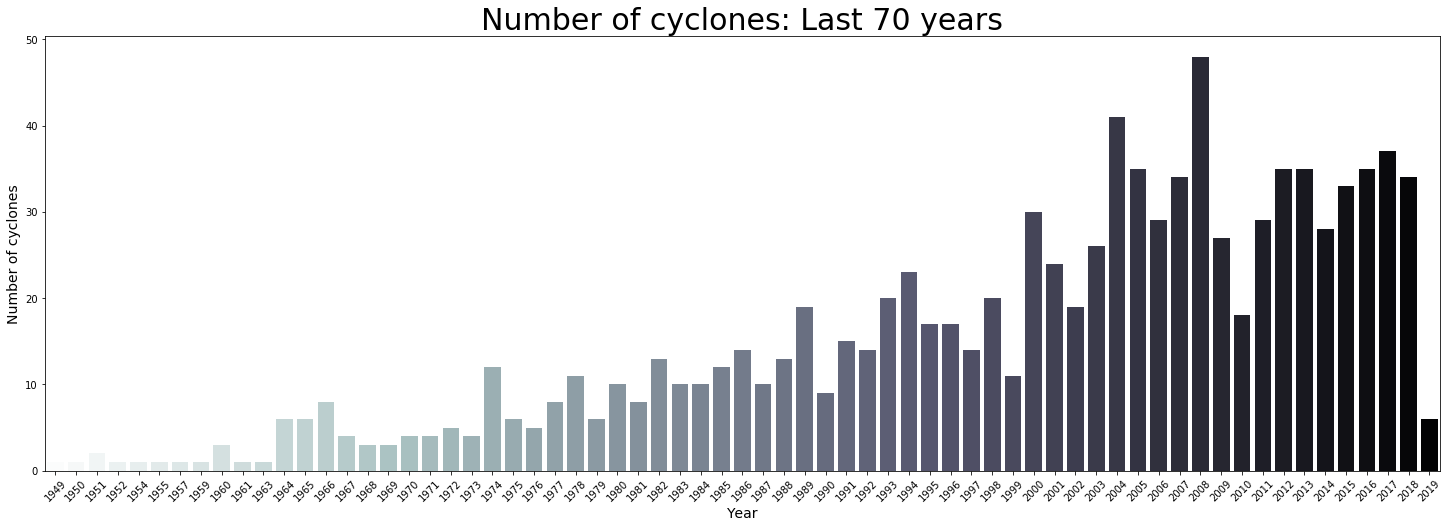

In [24]:
# List of cyclones by occurrence
fig, ax = plt.subplots(figsize=(25,8))
sns.countplot(data = model_data2,
              x= "YEAR",
              palette = "bone_r" ,
              #order= years,
              orient = 'h').set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title('Number of cyclones: Last 70 years', fontsize = 30)
ax.set_ylabel('Number of cyclones', fontsize=14);
ax.set_xlabel('Year', fontsize=14);


### 4.3.2. Storms by  General Category

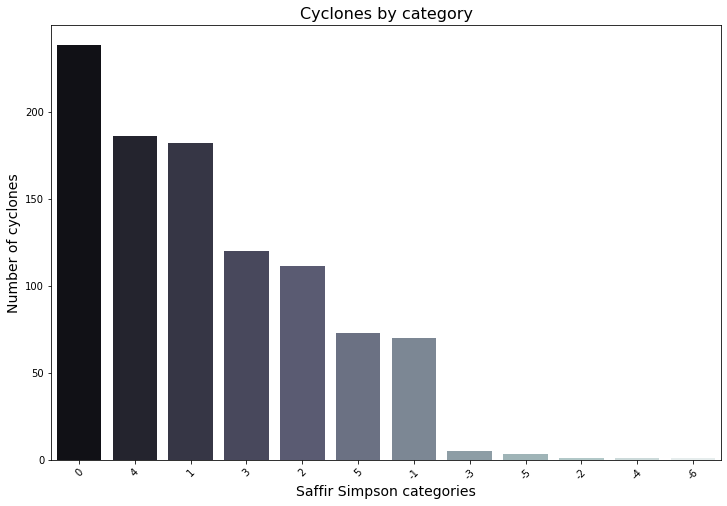

In [26]:
# List of cyclones by occurrence
Saffir_classification= list(model_data2['MAX_USA_SSHS'].value_counts().index)
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(data = model_data2,
              x= "MAX_USA_SSHS",
              order= Saffir_classification,
              palette = "bone",
              orient = 'h').set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title('Cyclones by category', fontsize= 16)
ax.set_ylabel('Number of cyclones', fontsize=14);
ax.set_xlabel('Saffir Simpson categories', fontsize=14);


Most of the cyclones in our data set are **Tropical Storms** and **Hurricane Category 4 and Category 1**.

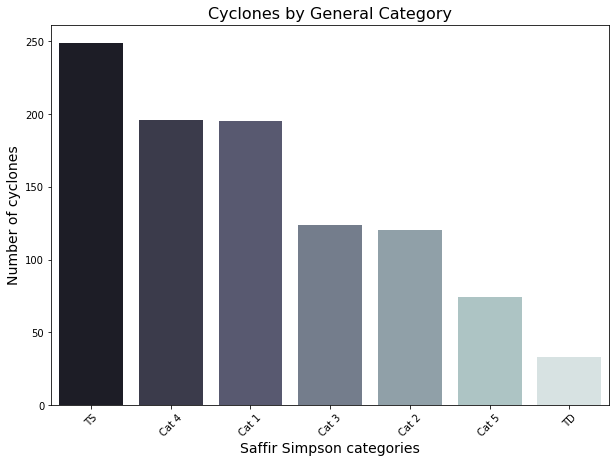

In [27]:
# List of cyclones by occurrence
Saffir_classification= list(model_data2['GENERAL_CATEGORY'].value_counts().index)
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data = model_data2,
              x= "GENERAL_CATEGORY",
              order= Saffir_classification,
              palette = "bone",
              orient = 'h').set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title('Cyclones by General Category', fontsize= 16)
ax.set_ylabel('Number of cyclones', fontsize=14);
ax.set_xlabel('Saffir Simpson categories', fontsize=14);


After introduction of the variable ``GENERAL_CATEGORY`` which classify the cyclone according with the maximum sustained winds it tooks during their trajectory, we have a much better landscape. Most of our cyclones are **Tropical Storms** and **Hurricanes Category 1 and 4**. Generally, after a cyclone reach winds which classify it as Category 1, there are affected population and some infrastructure damages.

### 4.3.4. Cyclones by Sub-basin

Let us see what is the big region more threatened by hurricans with population affected data:

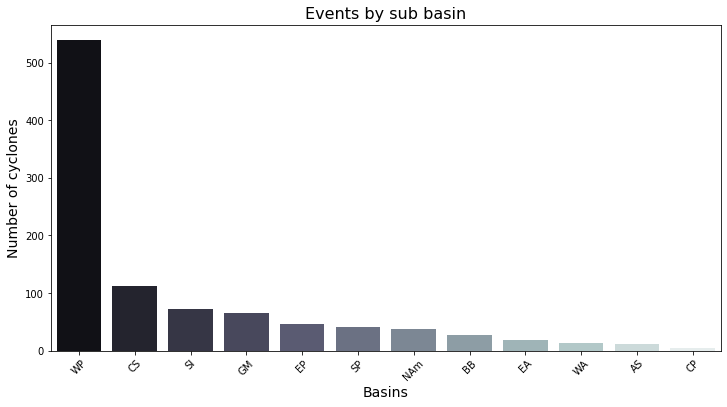

In [28]:
# List of cyclones by occurrence
basins= list(model_data2['SUB BASIN'].value_counts().index)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(data = model_data2,
              x= "SUB BASIN",
              palette= "bone",
              order= basins,
              orient = 'h').set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title('Events by sub basin', fontsize= 16)
ax.set_ylabel('Number of cyclones', fontsize=14);
ax.set_xlabel('Basins', fontsize=14);


By far, most of the storms for which we have data have occurred in **Western North Pacific** basin.

### Countries with more cyclone frequence

In [29]:
countries_to_plot = model_data2.groupby("ISO")[["SID"]].agg("count").reset_index().rename(columns = {"SID": "Nº_cyclones"})

In [304]:
fig = px.choropleth(countries_to_plot, locations="ISO",
                    color="Nº_cyclones", 
                    hover_name="ISO", # column to add to hover information
                    color_continuous_scale=oslorev,
                    projection='natural earth')
fig.update_layout(
    title_text = 'Occurrence of cyclones by countries')

fig.show()



Philipines, China, Japan, Mexico, Vietnam, United States and Madagascar are the countries with highest occurrence of cyclones. In GitHub, please see the static image [here](https://github.com/omdena/wfpdisrel/blob/master/%23task3-model/model-e-RandomForest/Plots/map.png)


## 4.4. Correlation matrix for categorical features 

We will use contingency tables for analyzing whether there is some correlation between people affected, the sub-basin of the cyclone and the intensity of it according with the Saffir-Simpson-Scale in our data.

In [31]:
#create a copy of our data set for further binning

md = model_data2.copy()


In [32]:
dict_cats = {"Cat 1": "Cat-1-C",
             "Cat 2": "Cat-2-C",
             "Cat 3": "Cat-3-C",
             "Cat 4": "Cat-4-C",
             "Cat 5": "Cat-5-C"}

def set_cat(cat):
    if cat in ["TD", "TS"]:
        return "Cat 0"
    else:
        return cat

    
dict_income = {"High": "4",
               "High_Middle": "3",
               "Low": "1",
               "Low_Middle": "2"}

def set_income(level):
    return dict_income[level]
    
md["GENERAL_CATEGORY"] = md.GENERAL_CATEGORY.apply(set_cat)

md["INCOME_LEVEL"] = md.INCOME_LEVEL.apply(set_income)

cont_table = pd.crosstab(md["GENERAL_CATEGORY"], 
                         md["SUB BASIN"], 
                         values = md["TOTAL_AFFECTED"], 
                         aggfunc= "mean").sort_values("GENERAL_CATEGORY")

for col in cont_table.columns:
    cont_table[col] = cont_table[col].apply(lambda x: math.log(x, 10))

In [33]:
#create a copu of our data set for further binning
cont_table2 = pd.crosstab(md["GENERAL_CATEGORY"], 
                         md["INCOME_LEVEL"], 
                         values = md["TOTAL_AFFECTED"], 
                         aggfunc= "mean").sort_values("GENERAL_CATEGORY")

for col in cont_table2.columns:
    cont_table2[col] = cont_table2[col].apply(lambda x: math.log(x, 10))

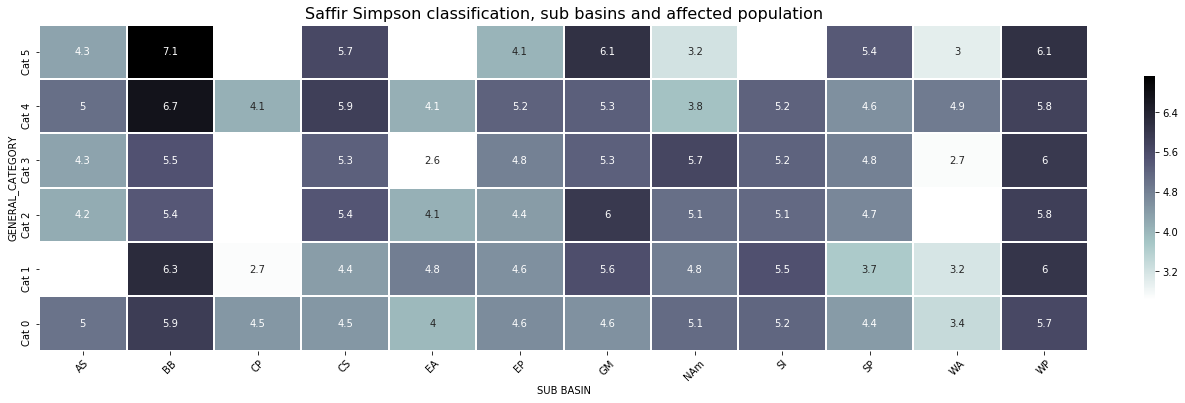

In [34]:
fig, ax = plt.subplots(figsize=(20,6))

#We use the function crosstab in pandas to create a contingency table, crossing USA_SSHS and SUB BASIN by computing the mean of the affected population
sns.heatmap(cont_table,
            cmap="bone_r", 
            cbar_kws={'fraction' : 0.01}, # shrink colour bar
            linewidth=1, # space between cells
            ax = ax,
            annot = True).set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set(ylim=(0, 6));

ax.set_title("Saffir Simpson classification, sub basins and affected population", fontsize= 16);

Here we consider the tropical depressions and tropical storms together as Cat 0. We can do this because there are little tropical depressions in our data. Most of the basins have the highest number of affected people increasing as the category of the cyclone increases, except the North Atlantic basin for which we have very little data.

In the West Pacific basin, for which we have most data, the mean affected people by the cyclone is going upwards most of the time when the category of the cyclone increases.

After this, we will include the feature ``GENERAL_CATEGORY`` as a dummy variable in our data set.

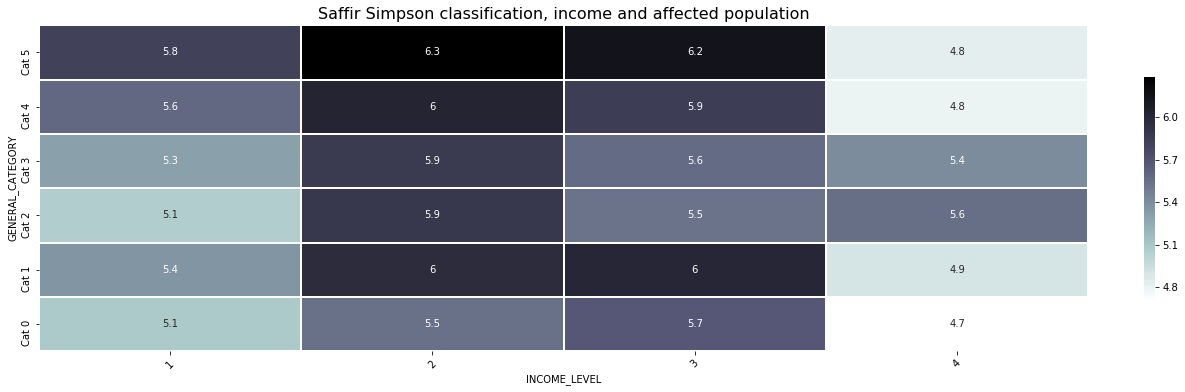

In [35]:
#create a copu of our data set for further binning
cont_table2 = pd.crosstab(md["GENERAL_CATEGORY"], 
                         md["INCOME_LEVEL"], 
                         values = md["TOTAL_AFFECTED"], 
                         aggfunc= "mean").sort_values("GENERAL_CATEGORY")

for col in cont_table2.columns:
    cont_table2[col] = cont_table2[col].apply(lambda x: math.log(x, 10))
fig, ax = plt.subplots(figsize=(20,6))

#We use the function crosstab in pandas to create a contingency table, crossing category and income
#by computing the mean of the affected population
sns.heatmap(cont_table2,
            cmap="bone_r", 
            cbar_kws={'fraction' : 0.01}, # shrink colour bar
            linewidth=1, # space between cells
            ax = ax,
            annot = True).set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set(ylim=(0, 6));

ax.set_title("Saffir Simpson classification, income and affected population", fontsize= 16);

We can see than, in general countries with higher income level have less affected population in each cyclone category. Critical sectors are countries with ``INCOME_LEVEL`` Low middle and High Middle.

We will include ``INCOME_LEVEL`` as a dummy variable in our data set.

## 4.5. Plus: Correlation matrix for our numerical features

We will construct a function which allows us to do the same procedure for different datasets:

In [306]:
def get_correlation_matrix(data, method_corr):
    numerical_variables = list(data.select_dtypes(include=['float64', "int"]).columns)
    data_num = data[numerical_variables].copy()
    corr_numbers = data_num.corr(method = method_corr)
    corr_num_list = list(corr_numbers[abs(corr_numbers["TOTAL_AFFECTED"])>=0.10].index)
    corr_plot = corr_numbers[corr_numbers.index.isin(corr_num_list)][corr_num_list]
    n = len(corr_num_list)
    
    mask = np.zeros_like(corr_plot, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False
    
    fig, ax = plt.subplots(figsize=(13,15))

    sns.heatmap(corr_plot,
                mask = mask,
                annot = True,
                square=True,
                linewidth=1,# space between cells
                cmap= "twilight_shifted",#"PRGn", 
                cbar_kws={'fraction' : 0.03}, # shrink colour bar
                ax = ax,
               );
    ax.set(ylim=(0, n));
    ax.set_title(method_corr.capitalize() +" correlation coefficient: correlation with TOTAL_AFFECTED >= 0.10", fontsize=17);

def get_correlation_features(data, method_corr, col):
    numerical_variables = list(data.select_dtypes(include=['float64', "int"]).columns)
    data_num = data[numerical_variables].copy()
    corr_numbers = data_num.corr(method = method_corr)
    corr_num_list = list(corr_numbers[abs(corr_numbers["TOTAL_AFFECTED"])>=0.10].index)
    corr_plot = corr_numbers[corr_numbers.index.isin(corr_num_list)][corr_num_list]
    corr_plot = corr_plot[[col]]
    corr_plot["absolute coeficient"] = corr_plot[col].apply(lambda x: abs(x))
    corr_plot = corr_plot.sort_values("absolute coeficient", ascending= False).reset_index()
    corr_plot = corr_plot.rename(columns = {"index": "Features", col: "Correlation coeficient"})
    return corr_plot[["Features", "Correlation coeficient"]].drop(0, axis = 0)

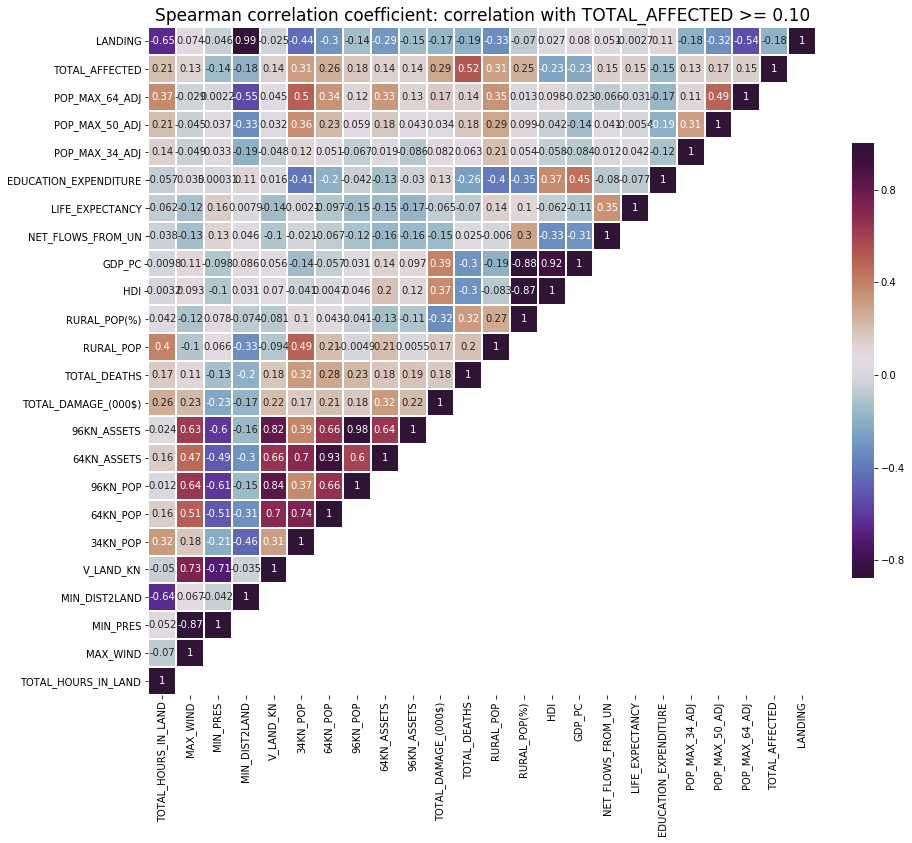

In [307]:
get_correlation_matrix(model_data2, "spearman")

# 5. How is the distribution of the population affected in our data?


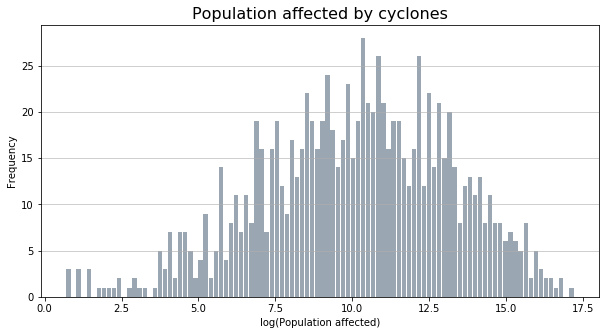

In [314]:
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(x=model_data2["TOTAL_AFFECTED"].apply(lambda x: math.log(x)), 
                            bins=100, 
                            color='slategrey',
                            alpha=0.7, 
                            rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('log(Population affected)')
plt.ylabel('Frequency')
plt.title('Population affected by cyclones', fontsize= 16)
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10);


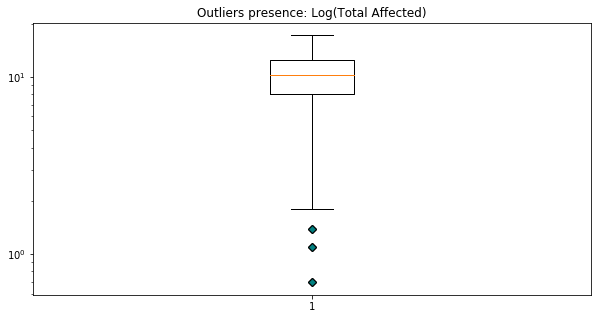

In [327]:
teal_diamond = dict(markerfacecolor='teal', marker='D')
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Outliers presence: Log(Total Affected)');
ax.boxplot(model_data2["TOTAL_AFFECTED"].apply(lambda x: math.log(x)), flierprops=teal_diamond);
ax.set_yscale('log')


Observed that the distribution of the logarithm natural of our target variable is approximately normal, so ``TOTAL_AFFECTED`` has a distribution log normal. For this reason, when studying the relevance of the categorical features as ``BASIN``, ``SUB BASIN`` and ``USA_SSHS`` in the target variable, we have considered take the aggregated function as the **mean** of the data.


# 6. Feature engineering, handling categorical variables

After seeing the relevance of certain variables for our model, we decided to keep ``GENERAL_CATEGORY`` as a categorical variable and ``SUB BASIN``. Also, we will introduce a boolean variable for landing or not landing:

In [80]:
# get dummy variables
model_data2 = pd.get_dummies(model_data2, columns=["GENERAL_CATEGORY", "INCOME_LEVEL"], prefix = ["GEN", "INCOME"])

In [81]:
model_data2["LANDING"] = model_data2["DATE_LAND_START"].apply(lambda x: 0 if x!="No landing" else 1)

Since we want to predict affected population, data about deaths and damage are a posteriori. Therefore, we drop those variables as well:

In [82]:
apriori = model_data2.drop(columns = ["DATE_LAND_START", "DATE_LAND_END", "MAX_USA_SSHS", "MAX_USA_SSHS_INLAND", "NATURE", "TOTAL_DEATHS", "TOTAL_DAMAGE_(000$)"])

In [83]:
apriori

,SID,NAME,ISO,YEAR,SUB BASIN,MONTH_START,MONTH_END,DATE_START,DATE_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,LAT_MAX_WINDS,LON_MAX_WINDS,LAT_MIN_DIST2LAND,LON_MIN_DIST2LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,POP_DEN_SQ_KM,RURAL_POP,RURAL_POP(%),HDI,ARABLE_LAND,CEREAL_YIELD,FOOD_PRODUCTION_INDEX,GDP_PC,NET_FLOWS_FROM_UN,LIFE_EXPECTANCY,EDUCATION_EXPENDITURE,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED,GEN_Cat 1,GEN_Cat 2,GEN_Cat 3,GEN_Cat 4,GEN_Cat 5,GEN_TD,GEN_TS,INCOME_High,INCOME_High_Middle,INCOME_Low,INCOME_Low_Middle,LANDING
0,1949163N07145,DELLA,JPN,1949,WP,6,6,1949-06-19 09:00:00,1949-06-24 06:00:00,117.0,60.0,28.91410,129.5730,33.5183,130.973,116.0,952,0,33.0,99.82,3889.480640,3632.626180,NaN,NaN,NaN,NaN,NaN,NaN,195.0,63072400.0,77.20,0.816,0.059615,4173.500000,67.790000,8607.657082,0.0,67.666098,2.867878,1.198300e+07,5.803981e+09,3.320907e+09,194046,0,0,0,1,0,0,0,0,0,1,0,0
1,1950241N23140,JANE,JPN,1950,WP,8,9,1950-08-30 03:00:00,1950-05-09 00:00:00,141.0,21.0,29.12010,133.7620,36.1016,136.095,116.0,940,0,31.0,99.82,3596.090691,2787.480021,NaN,NaN,NaN,NaN,NaN,NaN,227.0,38916000.0,47.00,0.816,0.059615,4173.500000,67.790000,8607.657082,0.0,67.666098,2.867878,3.160822e+07,1.559196e+07,1.018936e+07,642117,0,0,0,1,0,0,0,0,0,1,0,0
2,1951224N12316,CHARLIE,JAM,1951,CS,8,8,1951-08-17 21:00:00,1951-08-18 12:00:00,15.0,3.0,17.60000,-76.2000,17.9000,-76.900,110.0,0,0,17.0,132.40,438.214691,435.729082,2788659.0,2788659.0,2552903.0,2.148198e+10,2.148198e+10,1.948346e+10,133.0,953712.0,66.23,0.668,0.100541,868.300000,69.930000,3796.219401,0.0,64.770000,2.578304,1.689243e+09,1.687083e+06,1.195052e+09,20200,0,0,1,0,0,0,0,0,0,1,0,0
3,1951337N09150,AMY,PHL,1951,WP,12,12,1951-07-12 09:00:00,1951-12-17 00:00:00,231.0,36.0,11.78330,127.9000,10.5340,123.174,120.0,924,0,11.0,119.20,2238.058669,1905.587795,20464826.0,12675908.0,5618193.0,1.131050e+11,1.880280e+11,4.897333e+10,64.5,14467200.0,75.35,0.590,0.180442,996.300000,25.680000,1059.467412,0.0,61105.000000,2.757732,4.760039e+09,3.006670e+09,1.114774e+06,60000,0,0,0,1,0,0,0,0,0,0,1,0
4,1952180N05144,EMMA,PHL,1952,WP,7,7,1952-01-07 06:00:00,1952-04-07 18:00:00,84.0,9.0,9.56613,127.7910,10.6492,123.239,110.0,968,0,15.0,110691.00,1876.186790,1797.712213,NaN,NaN,NaN,NaN,NaN,NaN,66.9,14409590.0,72.41,0.590,0.180442,996.300000,25.680000,1059.467412,0.0,61105.000000,2.757732,5.130796e+09,2.789486e+06,1.988524e+09,103,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,2019068S17040,IDAI,MOZ,2019,SI,3,3,2019-09-03 06:00:00,2019-03-14 12:00:00,126.0,0.0,-19.75000,37.5758,-17.0000,40.200,105.0,944,70,12.0,151.20,957.628405,522.204526,NaN,NaN,NaN,NaN,NaN,NaN,39.9,19486400.0,64.10,0.217,0.204973,831.865274,147.309625,585.650609,0.0,58.508514,5.380000,2.396895e+09,0.000000e+00,0.000000e+00,1501500,0,0,1,0,0,0,0,0,0,1,0,1
987,2019068S17040,IDAI,MDG,2019,SI,3,3,2019-09-03 21:00:00,2019-12-03 12:00:00,63.0,0.0,-17.64990,42.5424,-17.3000,43.200,105.0,956,77,7.0,151.20,404.150545,211.930107,NaN,NaN,NaN,NaN,NaN,NaN,46.4,16767000.0,62.10,0.404,0.141861,3825.634771,121.054617,478.761938,0.0,66.012095,2.080000,2.341183e+05,0.000000e+00,0.000000e+00,1100,0,0,1,0,0,0,0,0,0,1,0,1
988,2019113S10051,KENNETH,COM,2019,SI,4,4,2019-04-24 03:00:00,2019-04-25 06:00:00,27.0,0.0,-11.60000,41.8000,-11.6000,41.800,124.0,937,138,13.0,118.80,486.400190,484.370217,NaN,NaN,NaN,NaN,NaN,NaN,457.0,604550.4,71.04,0.402,0.082332,1354.663449,108.375163,1375.714129,0.0,63.742834,4.326607,NaN,NaN,NaN,345311,0,0,0,1,0,0,0,0,0,0,1,1
989,2019113S10051,KENNETH,MOZ,2019,SI,4,4,2019-04-25 09:00:00,2019-04-26 12:00:00,27.0,21.0,-11.85760,41.2852,-12.5000,39.300,121.0,939,0,11.0,119.00,336.098173,304.360948,NaN,N

### 6.5.1. **What are the most correlated variables with ``TOTAL_AFFECTED``?**

In [115]:
get_correlation_features(model_data2, "spearman", "TOTAL_AFFECTED").head(12)

,Features,Correlation coeficient
1,TOTAL_DEATHS,0.521623
2,34KN_POP,0.313103
3,RURAL_POP,0.305599
4,TOTAL_DAMAGE_(000$),0.287962
5,64KN_POP,0.260846
6,RURAL_POP(%),0.249751
7,HDI,-0.230856
8,GDP_PC,-0.225501
9,TOTAL_HOURS_IN_LAND,0.209744
10,96KN_POP,0.184835


The top 10 most important features, out of the a posteriori ones, are:

* 34_KN_POP
* Rural population
* 64_KN_POP
* Rural population share
* Human Development Index (HDI)
* GDP per capita
* Total hours in land
* 96_KN_POP
* Landing (yes/no)
* Minimum distance to land

None of the a priori variables shows high correlation in general. 

### 6.5.2. What is the porportion of cyclones that actually land?

In [119]:
#creating tidy table
landing = (apriori.groupby("LANDING").agg({"DATE_START": "count", "TOTAL_AFFECTED": "sum"})
                   .reset_index()
                   .rename(columns = {"DATE_START": "Number of cyclones"}))

landing["LANDING"] = landing["LANDING"].apply(lambda x: "Landing"  if x== 0 else "No landing")

In [137]:
palette = ["slategrey", 'black'] #'rgb(105,105,105)'

fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=["Number of cyclones", 'People affected'])

fig.add_trace(go.Pie(labels=landing["LANDING"], 
                     values=landing["Number of cyclones"],
                      hole=.3,
                      marker_colors= palette,
                      name = ""), 1, 1)

fig.add_trace(go.Pie(labels=landing["LANDING"], 
                     values=landing["TOTAL_AFFECTED"], 
                     hole=.3,
                     marker_colors= palette,
                     name = ""), 1, 2)

fig.update_layout(title_text='Cyclones landing and people affected')
fig.show()


Almost 3 of each 4 cyclones present in our data did land. Those cyclones are responsible for almost 95% of the affected population in our data. 



# 6. Working with Random Forest Regressor

First we will import the relevant libraries.

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_squared_log_error, explained_variance_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import GridSearchCV

In [179]:
train = apriori.copy()

In [180]:
train.drop(columns = ["SID", "NAME", "ISO", "YEAR", "SUB BASIN", "DATE_START", "DATE_END" ], inplace= True)

In [181]:
train.columns

Index(['MONTH_START', 'MONTH_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND',
       'LAT_MAX_WINDS', 'LON_MAX_WINDS', 'LAT_MIN_DIST2LAND',
       'LON_MIN_DIST2LAND', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS', 'POP_DEN_SQ_KM',
       'RURAL_POP', 'RURAL_POP(%)', 'HDI', 'ARABLE_LAND', 'CEREAL_YIELD',
       'FOOD_PRODUCTION_INDEX', 'GDP_PC', 'NET_FLOWS_FROM_UN',
       'LIFE_EXPECTANCY', 'EDUCATION_EXPENDITURE', 'POP_MAX_34_ADJ',
       'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'TOTAL_AFFECTED', 'GEN_Cat 1',
       'GEN_Cat 2', 'GEN_Cat 3', 'GEN_Cat 4', 'GEN_Cat 5', 'GEN_TD', 'GEN_TS',
       'INCOME_High', 'INCOME_High_Middle', 'INCOME_Low', 'INCOME_Low_Middle',
       'LANDING'],
      dtype='object')

Before go further with the modelling part, it is necessary to fill the null values in the data set. We wil create a function to do so, in order to validate the performance of different strategies to fill the null values.

In [182]:
from sklearn.impute import SimpleImputer

In [183]:
def imput_values(data, strategy):
    """
    Returns data imputed following the strategy specified.
    Strategy can be mean, median, most_frequent
    """
    imp_trial=SimpleImputer(missing_values=np.NaN, strategy=strategy)
    idata=pd.DataFrame(imp_trial.fit_transform(data))
    idata.columns=data.columns
    idata.index=data.index
    return idata


If we want to scale our data using logarithms, there is a detail. As the domain of $log_{a} = \mathbb{R}^{>0}$ for any real $a>0$, we have to modify the scaler accordingly. Since all our numerical features take values that are at least 0, a simple handling of the function will allow us to scale any of those features accordingly.

In [184]:
def log_scale(data, cols, base):
    """
    Apply log in the base specified to cols, a subset of data.columns.
    The function prevents to calculate the logarithm of zero given that
    all values in cols are at least 0.
    If base == "e", it computes the natural logarithm.
    """
    log_data = data.copy()
    if base == "e":
        for col in cols:
            log_data[col] = log_data[col].apply(lambda x: math.log(x+1))
    else:
        for col in cols:
            log_data[col] = log_data[col].apply(lambda x: math.log(x+1, base))
    return log_data

In [232]:
def revert(array, base):
    if base == "e":
        return np.exp(array) -1
    else:
        return base**array -1
    

Now, we create a couple of model validator functions:

In [258]:
def model_validator(data, strategy, test_size, cols, target):
    """
    Returns metrics and feature importances after running Random Forest algorithm
    on a dataset data, following the inputation strategy strategy, with a test size defined.
    cols is a subset of features of data without including the target variable.
    """
    
    idata= imput_values(data, strategy)
    X_i = idata[cols].values
    y_i = idata[target].values
    X_itrain, X_itest, y_itrain, y_itest = train_test_split(X_i, y_i, test_size=test_size, random_state=142)
    RandomForestRegModel= RandomForestRegressor()
    model_i = RandomForestRegModel.fit(X_itrain, y_itrain)
    pred_i = model_i.predict(X_itest)
    feat_importances = pd.Series(model_i.feature_importances_, index = cols)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "slategrey",
                                       title = "Feature importance" )
    print("Metrics results:")
    print("Inputting values following strategy {}".format(strategy))
    print("R2 Score: {}".format(r2_score(y_itest, pred_i)))
    print("Squared root of Mean Squared Error (RMSE): {}".format(math.sqrt(mean_squared_error(y_itest, pred_i))))
    print("Mean squared logarithmic error (RMSLE): {}".format(math.sqrt(mean_squared_log_error(y_itest, pred_i))))
    print("Explained Variance: {}".format(explained_variance_score(y_itest, pred_i)))
    print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_itest, pred_i, pred_i)))
    print("Median Absolute Error: {}".format(median_absolute_error(y_itest, pred_i)))
    

    

In [257]:
def model_validator_log(data, strategy, test_size, cols, target, cols_to_be_transformed, base):
    """
    Returns metrics and feature importances after running Random Forest algorithm
    on a dataset data, following the inputation strategy strategy, with a test size defined.
    cols is a subset of the columns of data without including the target variable.
    cols_to_be_transformed is a subset of data.columns to be transformed via log_scale function using
    the base specified.
    """
    idata= imput_values(data, strategy)
    idata = log_scale(idata, cols_to_be_transformed, base)
    X_i = idata[cols].values
    y_i = idata[target].values
    X_itrain, X_itest, y_itrain, y_itest = train_test_split(X_i, y_i, test_size=test_size, random_state=42)
    RandomForestRegModel= RandomForestRegressor()
    model_i = RandomForestRegModel.fit(X_itrain, y_itrain)
    pred_i = model_i.predict(X_itest)
    feat_importances = pd.Series(model_i.feature_importances_, index = cols)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "slategrey",
                                       title = "Feature importance" )
    print("Results metrics with logarithmic scaling in base {}".format(base))
    print("Inputting values following strategy {}".format(strategy))

    print("R2 Score: {}".format(r2_score(y_itest, pred_i)))
    print("Explained Variance: {}".format(explained_variance_score(revert(y_itest, base), revert(pred_i, base))))
    print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(revert(y_itest, base), revert(pred_i, base))))
    print("Squared Root Mean Squared Error (RMSE): {}".format(math.sqrt(mean_squared_error(revert(y_itest, base), revert(pred_i, base)))))
    print("Distorted RMSE (aka almost RMSLE) : {}".format(math.sqrt(mean_squared_error(y_itest, pred_i))))
    print("Median Absolute Error: {}".format(median_absolute_error(revert(y_itest, base), revert(pred_i, base))))
    

We have a default selection of features. Let us try out the performance of our model within this data:

In [249]:
#data set train without log transformations
trial = train.copy()

In [250]:
features = ['MONTH_START', 'MONTH_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND',
       'LAT_MAX_WINDS', 'LON_MAX_WINDS', 'LAT_MIN_DIST2LAND',
       'LON_MIN_DIST2LAND', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 
        'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', #'34KN_POP', '64KN_POP', '96KN_POP',
       'POP_DEN_SQ_KM',
       'RURAL_POP', 'RURAL_POP(%)', 'HDI', #'ARABLE_LAND', 'CEREAL_YIELD',
       #'FOOD_PRODUCTION_INDEX', 'GDP_PC', #'NET_FLOWS_FROM_UN',
       #'LIFE_EXPECTANCY', 'EDUCATION_EXPENDITURE',
        'POP_MAX_34_ADJ',
       'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'GEN_Cat 1',
       'GEN_Cat 2', 'GEN_Cat 3', 'GEN_Cat 4', 'GEN_Cat 5', 'GEN_TD', 'GEN_TS',
       #'INCOME_High', 'INCOME_High_Middle', 'INCOME_Low', 'INCOME_Low_Middle',
       'LANDING']

In [251]:
to_transform = ['34KN_POP', '64KN_POP', '96KN_POP',
        'POP_DEN_SQ_KM',
       'RURAL_POP', 'POP_MAX_34_ADJ',
       'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',"TOTAL_AFFECTED" ]

### Running models with scaled features

Results metrics with logarithmic scaling in base e
Inputting values following strategy median
R2 Score: 0.23870046294990965
Explained Variance: 0.024949264487483247
Mean Absolute Error (MAE): 562995.0991215785
Squared Root Mean Squared Error (RMSE): 2315487.260728654
Distorted RMSE (aka almost RMSLE) : 2.625496313442124
Median Absolute Error: 38892.17010572342


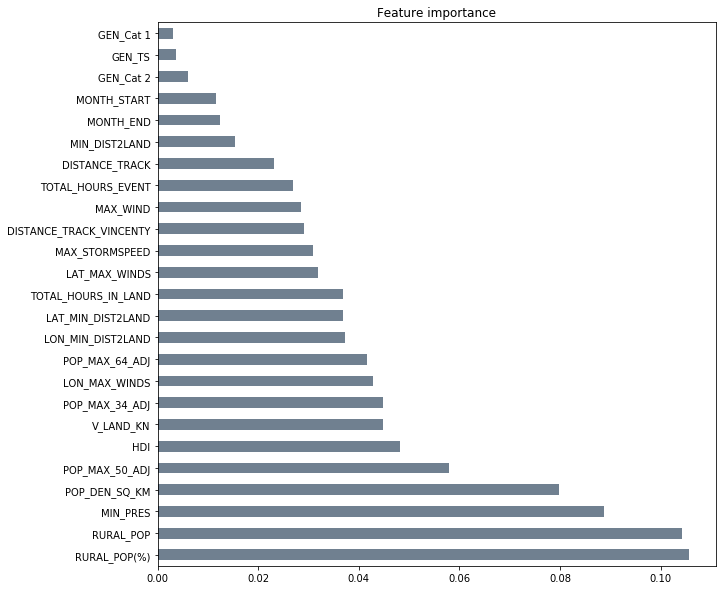

In [259]:
model_validator_log(trial, "median", 0.25, features, "TOTAL_AFFECTED", to_transform, "e")

Results metrics with logarithmic scaling in base 10
Inputting values following strategy median
R2 Score: 0.23111876088423988
Explained Variance: 0.027424282553793256
Mean Absolute Error (MAE): 557440.8966502696
Squared Root Mean Squared Error (RMSE): 2315410.4903271943
Distorted RMSE (aka almost RMSLE) : 1.1459022530785907
Median Absolute Error: 40535.68415085824


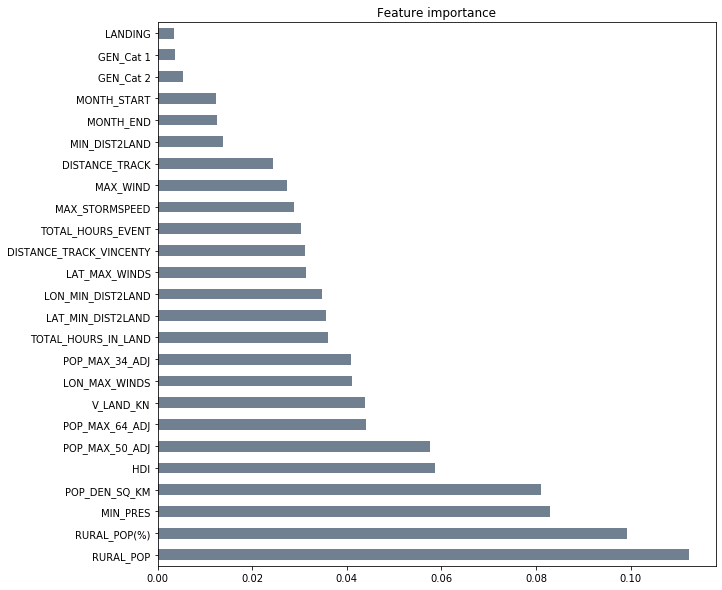

In [236]:
model_validator_log(trial, "median", 0.25, features, "TOTAL_AFFECTED", to_transform, 10)

**Conclusions**

* The choose of base for logarithmic transformations does not affect that much the performnce of the Random forest.
* After excluding a lot of features our model show better performance.

### Running models without scaling features

Metrics results:
Inputting values following strategy median
R2 Score: 0.29909250429974654
Squared root of Mean Squared Error (RMSE): 1617735.0275608804
Mean squared logarithmic error (RMSLE): 3.8801210477952046
Explained Variance: 0.3083498597143941
Mean Absolute Error (MAE): 2474179.6044586073
Median Absolute Error: 229126.11


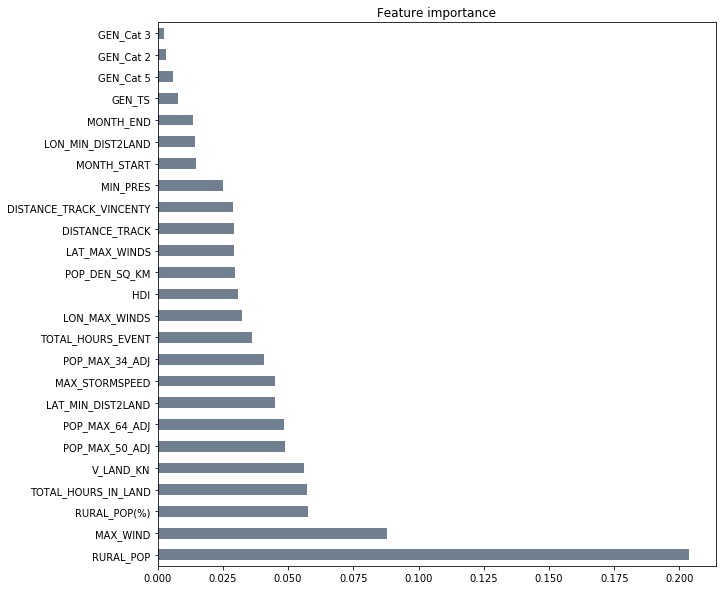

In [240]:
model_validator(trial, "median", 0.25, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy mean
R2 Score: 0.2486988994243552
Squared root of Mean Squared Error (RMSE): 1674881.3601798054
Mean squared logarithmic error (RMSLE): 3.912954767232344
Explained Variance: 0.2585385587245169
Mean Absolute Error (MAE): 2480867.661904866
Median Absolute Error: 240777.94


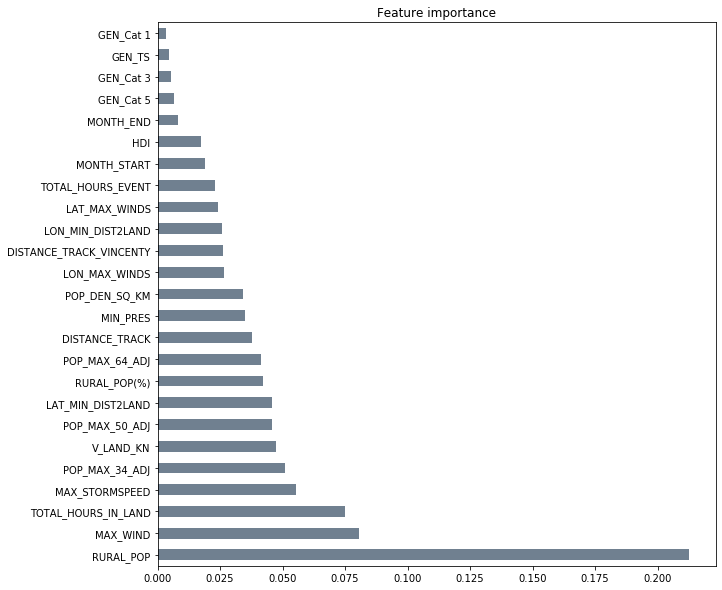

In [241]:
model_validator(trial, "mean", 0.25, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy most_frequent
R2 Score: 0.3047036879536871
Squared root of Mean Squared Error (RMSE): 1611246.5472648046
Mean squared logarithmic error (RMSLE): 3.868680329865224
Explained Variance: 0.3142552814454067
Mean Absolute Error (MAE): 2500030.1356809926
Median Absolute Error: 224680.105


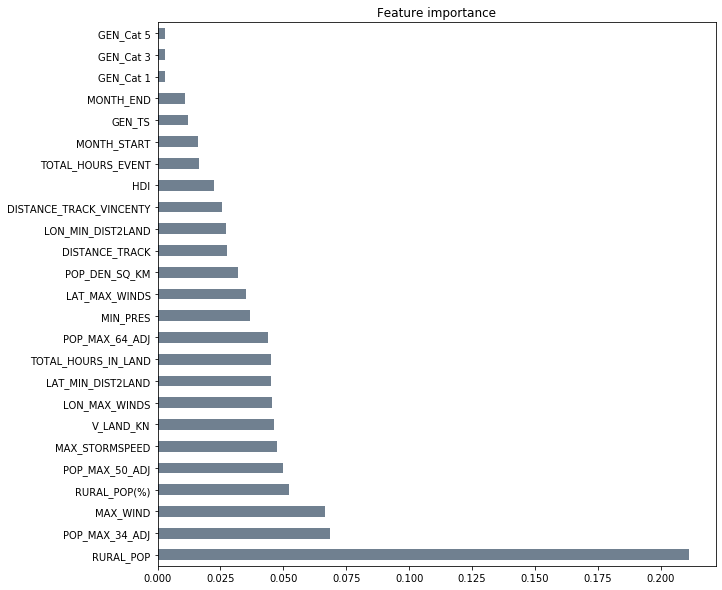

In [242]:
model_validator(trial, "most_frequent", 0.25, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy most_frequent
R2 Score: 0.2710560590976816
Squared root of Mean Squared Error (RMSE): 1568882.2219959204
Mean squared logarithmic error (RMSLE): 3.903979378870761
Explained Variance: 0.2858601782121999
Mean Absolute Error (MAE): 2390049.3362764684
Median Absolute Error: 242950.115


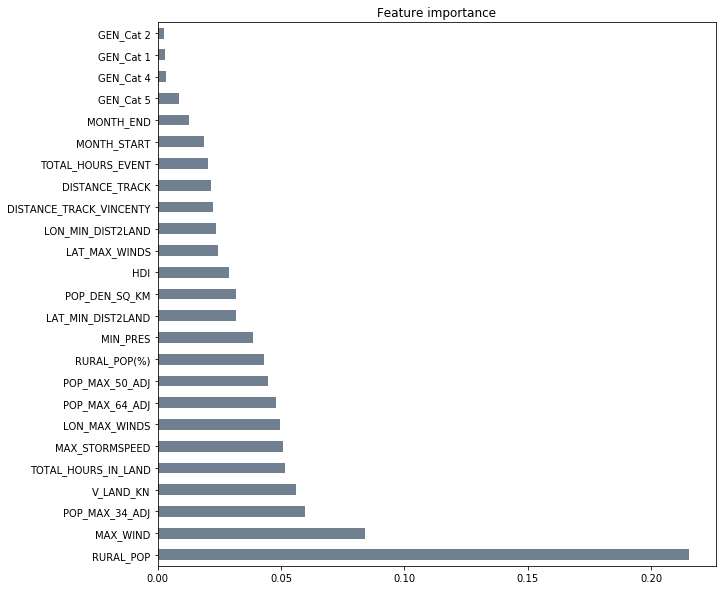

In [243]:
model_validator(trial, "most_frequent", 0.30, features, "TOTAL_AFFECTED")

**Conclusions**

* Random forest give us better metrics without logarithmic transformations. We reach almost 0.30 in R^2 score without any hyper parameter tuning. 

* The strategy to fill null values which improves the metrics are median and most frequent.

* The test size is better at 0.30 when choosing most_frequent strategy to fill nulls and 0.25 when using medians.

## 6.  Performance  of model with the original data set

Now, we will explore the performance of our model using the original data set, once dropped columns as ``TOTAL_DEATHS`` and ``TOTAL_DAMAGE_(000$)`` whose data is only available after assessing the occurrence of the cyclone.

In [297]:
def predictions_plot(data, strategy, test_size, cols, target):
    """
    Returns metrics and feature importances after running Random Forest algorithm
    on a dataset data, following the inputation strategy strategy, with a test size defined.
    cols is a subset of features of data without including the target variable.
    """
    
    idata= imput_values(data, strategy)
    X_i = idata[cols].values
    y_i = idata[target].values
    X_itrain, X_itest, y_itrain, y_itest = train_test_split(X_i, y_i, test_size=test_size, random_state=142)
    RandomForestRegModel= RandomForestRegressor()
    model_i = RandomForestRegModel.fit(X_itrain, y_itrain)
    pred_i = model_i.predict(X_itest)
        
    print("Metrics results:")
    print("Inputting values following strategy {}".format(strategy))
    print("R2 Score: {}".format(r2_score(y_itest, pred_i)))
    print("Squared root of Mean Squared Error (RMSE): {}".format(math.sqrt(mean_squared_error(y_itest, pred_i))))
    print("Mean squared logarithmic error (RMSLE): {}".format(math.sqrt(mean_squared_log_error(y_itest, pred_i))))
    print("Explained Variance: {}".format(explained_variance_score(y_itest, pred_i)))
    print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_itest, pred_i, pred_i)))
    print("Median Absolute Error: {}".format(median_absolute_error(y_itest, pred_i)))
    
    obs_pred = pd.DataFrame({'Observed':y_itest, 'Predicted':pred_i})
    obs_pred.sort_values("Observed", inplace= True)
    obs_pred.reset_index(drop = True, inplace= True)
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(obs_pred.index,
            obs_pred["Predicted"], 
            'o', c='blue', 
            alpha=0.5, 
            markeredgecolor='none',
            label = "Predicted values")
    ax.plot(obs_pred.index,
            obs_pred["Observed"], 
            c= "teal", 
            marker='.', 
            linestyle=':',
            label = "Observed values")
    ax.set_yscale('log')
    ax.set_title('Values observed and predicted', fontsize= 12)
    ax.set_ylabel('Affected population (log_10)', fontsize=12);
    ax.set_xlabel('Number of observations', fontsize=14)
    leg = ax.legend(loc='lower right');


Metrics results:
Inputting values following strategy most_frequent
R2 Score: 0.3089551062770519
Squared root of Mean Squared Error (RMSE): 1606312.9769352921
Mean squared logarithmic error (RMSLE): 3.8555497472668323
Explained Variance: 0.3176663845517834
Mean Absolute Error (MAE): 2475408.733775038
Median Absolute Error: 230200.735


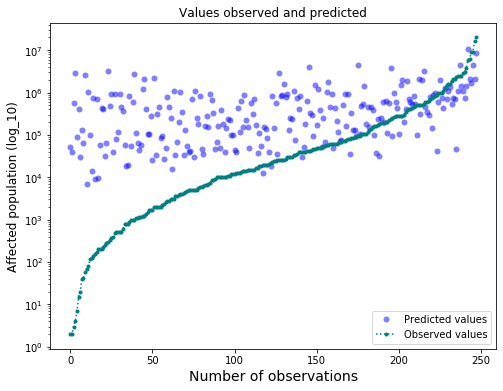

In [298]:
predictions_plot(trial, "most_frequent", 0.25, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy median
R2 Score: 0.265482970577409
Squared root of Mean Squared Error (RMSE): 1656067.2600167664
Mean squared logarithmic error (RMSLE): 3.882631803085861
Explained Variance: 0.2728437607367936
Mean Absolute Error (MAE): 2372856.279689762
Median Absolute Error: 242287.645


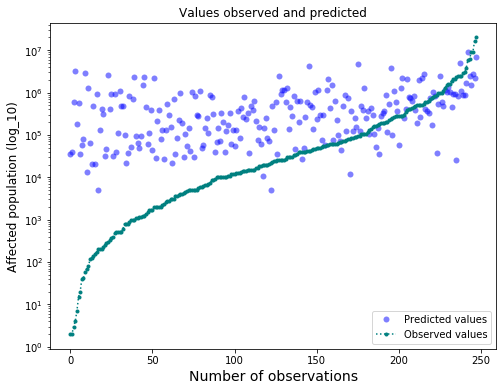

In [303]:
predictions_plot(trial, "median", 0.25, features, "TOTAL_AFFECTED")

**Conclusion**

* Our model is not performing well when taking samples of small affected population. It seems that by restringing our model to samplings having big affected population, our model will perform better.

* Using min_max scaler won't be solve the problem, given the huge gap between the values and possibly tuning hyperparameters will not be helpful given our skewed data set.  

### 7. Handling outliers 

The next step to do is get ride from outliers. We can see the presence of outliers in our target variable below:

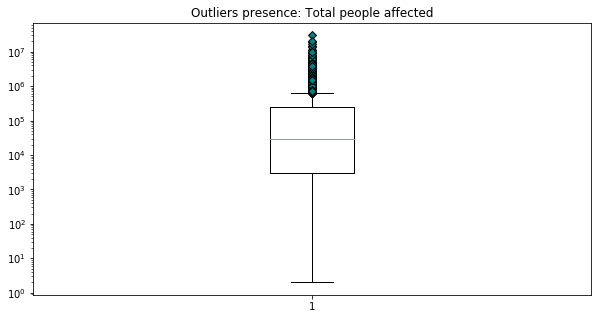

In [328]:
teal_diamond = dict(markerfacecolor='teal', marker='D')
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Outliers presence: Total people affected')
ax.boxplot(model_data2["TOTAL_AFFECTED"], 
           flierprops=teal_diamond)
ax.set_yscale('log');